First we have to mount drive for giving access to read the dataset

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive

Mounted at /gdrive
/gdrive


Next we import the necessary libraries to run the algorithm. In this case we use tensorflow and keras and form a CNN nerual network. The purpose is training the network to classify weather images base on Four categories

Found 1125 files belonging to 4 classes.
Using 900 files for training.
Found 1125 files belonging to 4 classes.
Using 225 files for validation.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                          

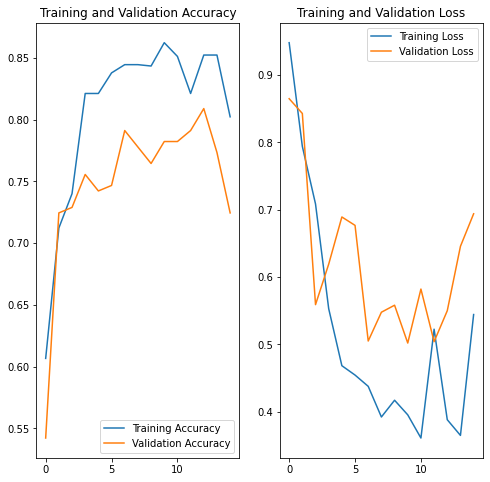

This image belongs to Sunrise class with the 99.87 percent of confidence.


In [3]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


class ImageClassifierWithCNN:
    __batch_size = 1
    __image_height = 180
    __image_width = 180
    __train_directory = None
    __train_dataset = None
    __validation_dataset = None
    __class_names = []
    __number_of_classes = 0
    __epochs = 20
    __model = None

    def __init__(self, training_data_dir):
        self.__train_directory = training_data_dir
        AUTO_TUNE = tf.data.AUTOTUNE
        self.__train_dataset = self.__init_train_dataset().cache().shuffle(1000).prefetch(buffer_size=AUTO_TUNE)
        self.__validation_dataset = self.__init_validation_dataset().cache().prefetch(buffer_size=AUTO_TUNE)
        self.__number_of_classes = len(self.__class_names)

    def __init_train_dataset(self):
        tds = tf.keras.utils.image_dataset_from_directory(
            self.__train_directory,
            validation_split=0.2,
            subset="training",
            seed=123,
            image_size=(self.__image_height, self.__image_width),
            batch_size=self.__batch_size)
        self.__class_names = tds.class_names
        return tds

    def __init_validation_dataset(self):
        return tf.keras.utils.image_dataset_from_directory(
            self.__train_directory,
            validation_split=0.2,
            subset="validation",
            seed=123,
            image_size=(self.__image_height, self.__image_width),
            batch_size=self.__batch_size)

    def __augment_data(self):
        return keras.Sequential(
            [
                layers.RandomFlip("horizontal",
                                  input_shape=(self.__image_height, self.__image_width, 3)), layers.RandomRotation(0.1),
                layers.RandomZoom(0.1),
            ]
        )

    def __fit_model(self):
        self.__model = Sequential([
            self.__augment_data(),
            layers.Rescaling(1. / 255),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(self.__number_of_classes)])
        self.__model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                             metrics=['accuracy'])
        self.__model.summary()
        history = self.__model.fit(self.__train_dataset, validation_data=self.__validation_dataset,
                                   epochs=self.__epochs)
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(self.__epochs)
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

    def predict(self, image):
        self.__fit_model()
        keras_image = tf.keras.utils.load_img(image, target_size=(self.__image_height, self.__image_width))
        array_image = tf.keras.utils.img_to_array(keras_image)
        array_image = tf.expand_dims(array_image, 0)
        predictions = self.__model.predict(array_image)
        score = tf.nn.softmax(predictions[0])
        print("This image belongs to {} class with the {:.2f} percent of confidence.".format(
            self.__class_names[np.argmax(score)], 100 * np.max(score)))

    def set_epochs(self, value):
        self.__epochs = value

    def get_epochs(self):
        return self.__epochs


cnn = ImageClassifierWithCNN("/gdrive/My Drive/Train Dataset")
cnn.set_epochs(15)
cnn.predict("/gdrive/My Drive/Samples/sunrise1.jpg")
